[[0.00338086 0.0021796  0.07677078 0.48226043 0.39212737 0.04328097]
 [0.00859823 0.04092144 0.62837463 0.30777002 0.00893811 0.00539756]
 [0.00515888 0.02630333 0.73126202 0.22825283 0.00591178 0.00311115]
 ...
 [0.00548749 0.00657384 0.34963823 0.59336944 0.03675715 0.00817385]
 [0.00492212 0.01760793 0.80864853 0.16359149 0.00304245 0.00218747]
 [0.00499953 0.00683505 0.33482289 0.61421392 0.03143292 0.00769568]]


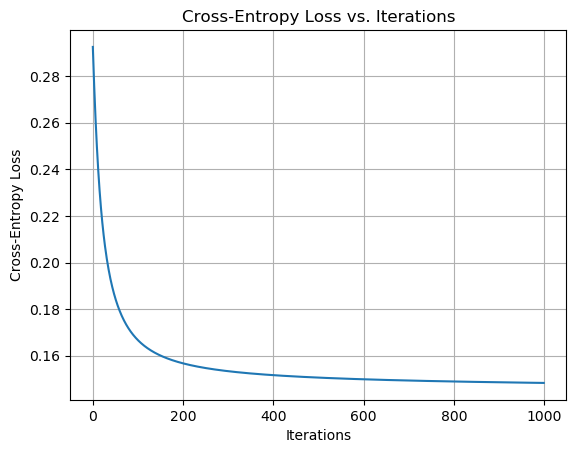

Test Accuracy: 0.6655518394648829


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('~/Downloads/winequality-red.csv')

# Function to remove outliers using IQR
def remove_outliers_iqr(data, features):
    Q1 = data[features].quantile(0.25)
    Q3 = data[features].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[~((data[features] < lower_bound) | (data[features] > upper_bound)).any(axis=1)]


remove = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                               'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
                               'pH', 'sulphates', 'alcohol']
data_cleaned = remove_outliers_iqr(data, remove)


X = data_cleaned[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                  'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
Y = data_cleaned['quality']

Y_encoded = pd.get_dummies(Y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.25, random_state=604)

def z_score_normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    return X_normalized

X_train_normalized = z_score_normalization(X_train)
X_test_normalized = z_score_normalization(X_test)


X_train_normalized_bias = np.c_[np.ones((X_train_normalized.shape[0], 1)), X_train_normalized]
X_test_normalized_bias = np.c_[np.ones((X_test_normalized.shape[0], 1)), X_test_normalized]

def softmax(logits):
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


def J(X, Y, theta):
    m = len(Y)
    logits = np.dot(X, theta)
    probs = softmax(logits)
    loss = -np.mean(Y * np.log(probs))
    return loss


'''def gradient_descent(X, Y, theta, learning_rate, iterations):
    m = len(Y)
    for _ in range(iterations):
        logits = np.dot(X, theta)
        probs = softmax(logits)
        error = probs - Y
        gradients = np.dot(X.T, error) / m
        theta -= learning_rate * gradients
    return theta'''

def gradient_descent(X, Y, theta, learning_rate, iterations):
    m = len(Y)
    COST = []  # To store the cost at each iteration
    for _ in range(iterations):
        logits = np.dot(X, theta)
        probs = softmax(logits)
        error = probs - Y
        gradients = np.dot(X.T, error) / m
        theta -= learning_rate * gradients
        cost = J(X, Y, theta)  # Calculate the cost at each iteration
        COST.append(cost)
    return theta, COST


num_features = X_train_normalized_bias.shape[1]

num_classes = 6
theta = np.zeros((num_features, num_classes))


learning_rate = 0.1
iterations = 1000
theta,COST = gradient_descent(X_train_normalized_bias, Y_train, theta, learning_rate, iterations)


test_logits = np.dot(X_test_normalized_bias, theta)
test_probs = softmax(test_logits)
print(test_probs)
test_predictions = np.argmax(test_probs, axis=1)

plt.plot(COST)
plt.xlabel('Iterations')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss vs. Iterations')
plt.grid(True)
plt.show()


test_accuracy = accuracy_score(np.argmax(Y_test.values, axis=1), test_predictions)


print("Test Accuracy:", test_accuracy)
